In [31]:
import pandas as pd
import numpy as np
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.fontsize": 11,
    "figure.dpi": 120
})


In [33]:
df = pd.read_csv("final_cow_thermal_dataset.csv")
df = df.drop(columns=["sample_folder"], errors="ignore")

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (51948, 11)


,cow_part,ambient_temp,humidity,mean_temp,max_temp,frame_std,delta_mean,delta_max,lactation,health_state,season
0,etc,17.6,83.2,24.34,26.05,3.20,6.74,8.45,0,healthy,winter
1,etc,17.0,82.9,23.66,26.15,3.02,6.66,9.15,0,healthy,winter
2,etc,16.9,83.7,22.76,26.13,2.82,5.86,9.23,0,healthy,winter
3,etc,16.8,84.2,22.34,24.84,2.81,5.54,8.04,0,healthy,winter
4,etc,16.8,84.2,22.14,25.42,2.90,5.34,8.62,0,healthy,winter


In [34]:
with open("artifacts/config/model_config.json") as f:
    model_config = json.load(f)

FEATURES = model_config["features"]

print("Features:", FEATURES)


Features: ['delta_mean', 'delta_max', 'frame_std', 'humidity']


In [35]:
with open("artifacts/config/thresholds.json") as f:
    thresholds = json.load(f)

thresholds


{'etc': -6.905007118144518,
 'eye': -5.865896590668073,
 'hoof': -5.4872687604504495,
 'leg': -6.504266088048517,
 'udder': -6.89888941530453}

In [36]:
gmm_models = {}
scalers = {}

for part in thresholds.keys():
    gmm_models[part] = joblib.load(
        f"artifacts/gmm_models/gmm_{part}.joblib"
    )
    scalers[part] = joblib.load(
        f"artifacts/scalers/scaler_{part}.joblib"
    )

print("Loaded models for:", list(gmm_models.keys()))


Loaded models for: ['etc', 'eye', 'hoof', 'leg', 'udder']


In [37]:
def compute_gmm_score(row):
    part = row["cow_part"]
    if part not in gmm_models:
        return np.nan

    x = pd.DataFrame([row[FEATURES]], columns=FEATURES)
    x_scaled = scalers[part].transform(x)

    return gmm_models[part].score_samples(x_scaled)[0]


In [38]:
df["gmm_score"] = df.apply(compute_gmm_score, axis=1)
df[["cow_part", "health_state", "gmm_score"]].head()


,cow_part,health_state,gmm_score
0,etc,healthy,-3.732525
1,etc,healthy,-4.227830
2,etc,healthy,-5.287482
3,etc,healthy,-4.024456
4,etc,healthy,-4.150791


In [39]:
def flag_abnormal(row):
    part = row["cow_part"]
    if part not in thresholds:
        return 0
    return int(row["gmm_score"] < thresholds[part])


In [40]:
df["abnormal"] = df.apply(flag_abnormal, axis=1)

pd.crosstab(
    df["health_state"],
    df["abnormal"],
    normalize="index"
)


abnormal,0,1
health_state,,
fever,0.449667,0.550333
healthy,0.949796,0.050204
lameness,0.008065,0.991935
mastitis,0.111000,0.889000


In [41]:
def infer_disease_from_part(row):
    if row["abnormal"] == 0:
        return {
            "predicted_condition": "normal",
            "confidence": 0.0
        }

    score_strength = min(1.0, abs(row["gmm_score"]) / 6)

    if row["cow_part"] == "udder":
        return {
            "predicted_condition": "mastitis_suspected",
            "confidence": round(score_strength, 2)
        }

    if row["cow_part"] in ["hoof", "leg"]:
        return {
            "predicted_condition": "lameness_suspected",
            "confidence": round(score_strength, 2)
        }

    if row["cow_part"] in ["eye", "body"] and score_strength > 0.4:
        return {
            "predicted_condition": "fever_or_infection_suspected",
            "confidence": round(score_strength, 2)
        }

    return {
        "predicted_condition": "abnormal_unspecified",
        "confidence": round(score_strength, 2)
    }


In [42]:
disease_df = df.apply(
    lambda r: pd.Series(infer_disease_from_part(r)),
    axis=1
)

df = pd.concat([df, disease_df], axis=1)


In [43]:
def assign_severity(row):
    if row["predicted_condition"] == "normal":
        return "NONE"

    conf = row["confidence"]

    if conf < 0.3:
        return "LOW"
    elif conf < 0.6:
        return "MEDIUM"
    else:
        return "HIGH"


In [44]:
df["severity"] = df.apply(assign_severity, axis=1)

df[["predicted_condition", "confidence", "severity"]].head()


,predicted_condition,confidence,severity
0,normal,0.0,NONE
1,normal,0.0,NONE
2,normal,0.0,NONE
3,normal,0.0,NONE
4,normal,0.0,NONE


In [45]:
pd.crosstab(
    df["predicted_condition"],
    df["severity"],
    normalize="index"
)


severity,HIGH,NONE
predicted_condition,,
abnormal_unspecified,1.0,0.0
fever_or_infection_suspected,1.0,0.0
lameness_suspected,1.0,0.0
mastitis_suspected,1.0,0.0
normal,0.0,1.0


# ****** Figures ******

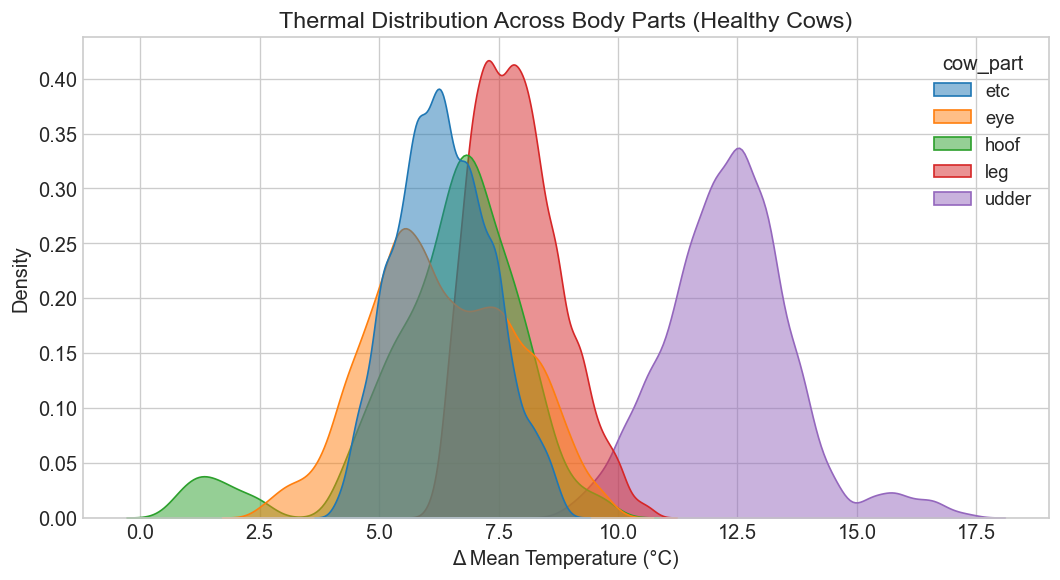

In [78]:
plt.figure(figsize=(9,5))

sns.kdeplot(
    data=df[df["health_state"]=="healthy"],
    x="delta_mean",
    hue="cow_part",
    fill=True,
    common_norm=False,
    alpha=0.5
)

plt.xlabel("Δ Mean Temperature (°C)")
plt.ylabel("Density")
plt.title("Thermal Distribution Across Body Parts (Healthy Cows)")
plt.tight_layout()
plt.show()


In [64]:
subset = df[df["cow_part"] == "etc"]

subset[["ambient_temp", "mean_temp", "delta_mean"]].describe()


,ambient_temp,mean_temp,delta_mean
count,12987.000000,12987.000000,12987.000000
mean,17.477778,23.826018,6.348240
std,0.383308,1.041236,0.977150
min,16.800000,21.588820,4.088820
25%,17.100000,23.035790,5.642895
50%,17.600000,23.780379,6.302530
75%,17.800000,24.571267,7.036860
max,18.000000,26.771870,8.971870


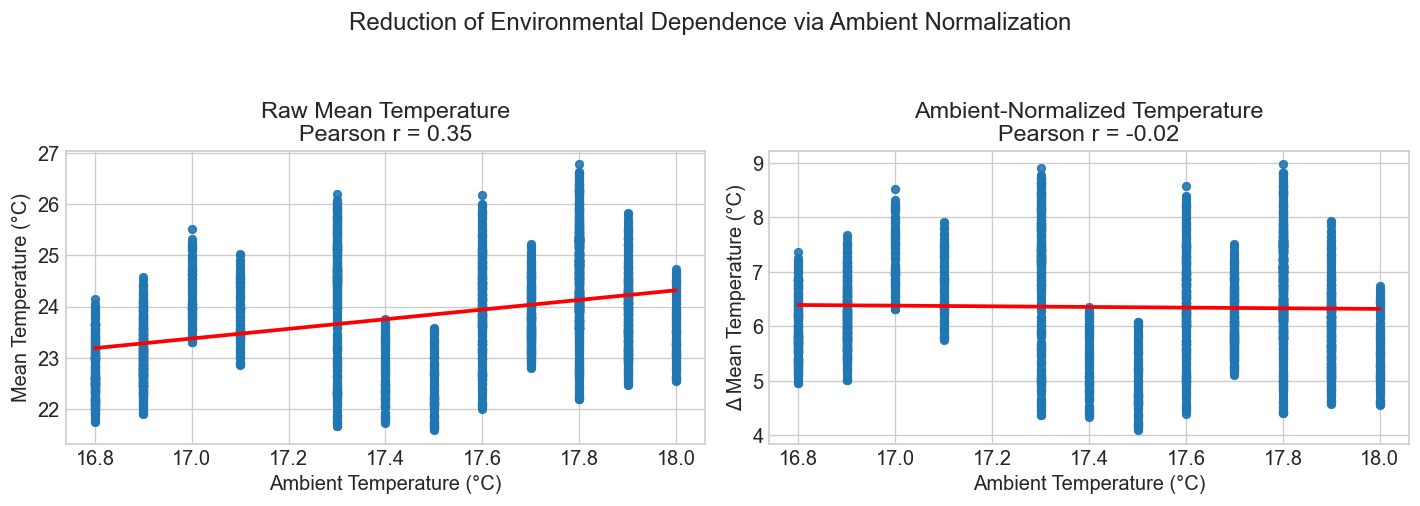

In [66]:
from scipy.stats import pearsonr

subset = df[df["cow_part"] == "etc"]

# Compute correlations
r_raw, _ = pearsonr(subset["ambient_temp"], subset["mean_temp"])
r_norm, _ = pearsonr(subset["ambient_temp"], subset["delta_mean"])

fig, axes = plt.subplots(1, 2, figsize=(12,4), sharex=True)

# Raw temperature
sns.regplot(
    data=subset,
    x="ambient_temp",
    y="mean_temp",
    scatter_kws={"alpha":0.4, "s":20},
    line_kws={"color":"red"},
    ax=axes[0]
)
axes[0].set_title(f"Raw Mean Temperature\nPearson r = {r_raw:.2f}")
axes[0].set_ylabel("Mean Temperature (°C)")
axes[0].set_xlabel("Ambient Temperature (°C)")

# Normalized temperature
sns.regplot(
    data=subset,
    x="ambient_temp",
    y="delta_mean",
    scatter_kws={"alpha":0.4, "s":20},
    line_kws={"color":"red"},
    ax=axes[1]
)
axes[1].set_title(f"Ambient-Normalized Temperature\nPearson r = {r_norm:.2f}")
axes[1].set_ylabel("Δ Mean Temperature (°C)")
axes[1].set_xlabel("Ambient Temperature (°C)")

plt.suptitle("Reduction of Environmental Dependence via Ambient Normalization", y=1.05)
plt.tight_layout()
plt.show()


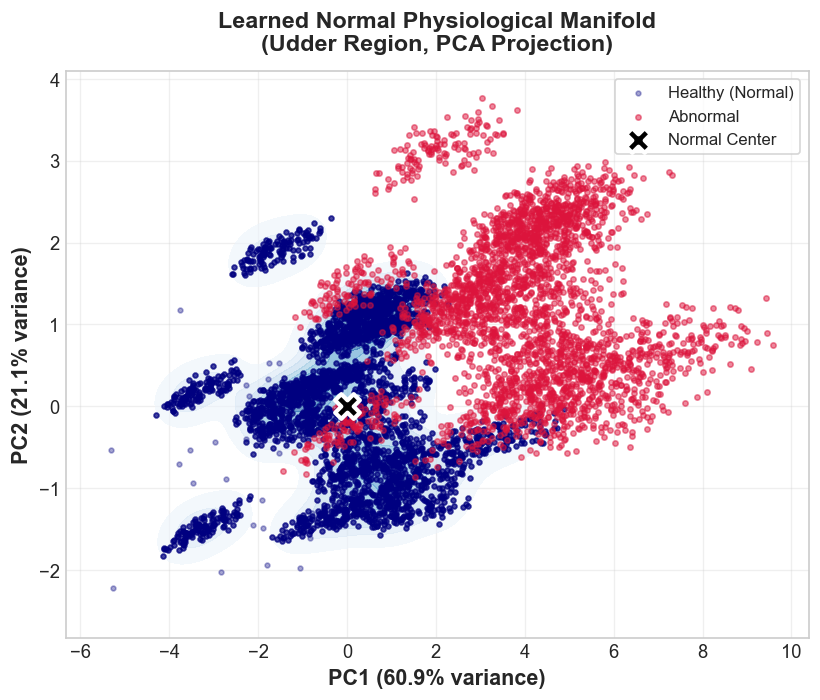

In [81]:
from sklearn.decomposition import PCA

part = "udder"

healthy = df[
    (df["cow_part"] == part) &
    (df["health_state"] == "healthy")
][FEATURES]

X = scalers[part].transform(healthy)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

var_exp = pca.explained_variance_ratio_
abnormal = df[
    (df["cow_part"] == part) &
    (df["health_state"] != "healthy")
][FEATURES]

X_abn = scalers[part].transform(abnormal)
X_abn_pca = pca.transform(X_abn)

plt.figure(figsize=(7,6))

# Healthy density
sns.kdeplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    levels=8,
    fill=True,
    cmap="Blues",
    alpha=0.6,
    thresh=0.05
)

# Healthy points
plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    s=8,
    color="navy",
    alpha=0.35,
    label="Healthy (Normal)",
    zorder=2
)

# Abnormal points
plt.scatter(
    X_abn_pca[:,0],
    X_abn_pca[:,1],
    s=10,
    color="crimson",
    alpha=0.5,
    label="Abnormal",
    zorder=3
)

# ---- NORMAL CENTER (FIXED) ----
plt.scatter(
    X_pca[:,0].mean(),
    X_pca[:,1].mean(),
    s=220,                 # bigger
    marker="X",
    color="black",
    edgecolor="white",     # strong contrast
    linewidth=2.5,
    label="Normal Center",
    zorder=5               # always on top
)

# ---- AXES (BOLDER & CLEARER) ----
plt.xlabel(
    f"PC1 ({var_exp[0]*100:.1f}% variance)",
    fontsize=13,
    fontweight="bold"
)
plt.ylabel(
    f"PC2 ({var_exp[1]*100:.1f}% variance)",
    fontsize=13,
    fontweight="bold"
)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.title(
    "Learned Normal Physiological Manifold\n(Udder Region, PCA Projection)",
    fontsize=14,
    fontweight="bold",
    pad=12
)

plt.legend(
    frameon=True,
    fontsize=10
)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


PCA data preparation (lameness)

In [82]:
from sklearn.decomposition import PCA

# Combine hoof + leg
part_mask = df["cow_part"].isin(["hoof", "leg"])

healthy = df[
    part_mask &
    (df["health_state"] == "healthy")
][FEATURES]

abnormal = df[
    part_mask &
    (df["health_state"] == "lameness")
][FEATURES]

# Scale using one of the trained scalers (hoof & leg share physiology scale)
scaler = scalers["hoof"] if "hoof" in scalers else scalers["leg"]

X_h = scaler.transform(healthy)
X_a = scaler.transform(abnormal)

# PCA
pca = PCA(n_components=2)
X_h_pca = pca.fit_transform(X_h)
X_a_pca = pca.transform(X_a)

var_exp = pca.explained_variance_ratio_


PCA FIGURE(Lameness)

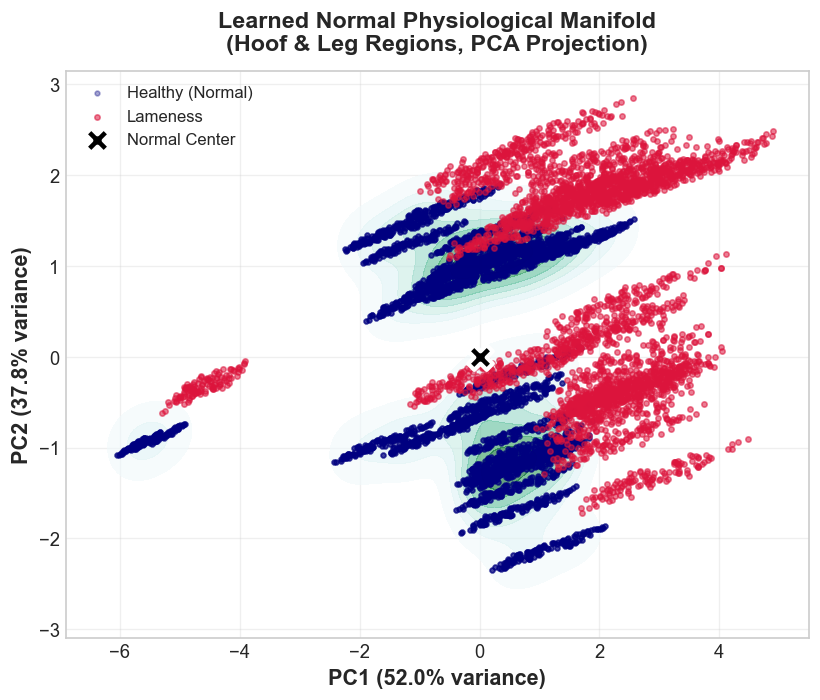

In [87]:
plt.figure(figsize=(7,6))

# Healthy density (normal manifold)
sns.kdeplot(
    x=X_h_pca[:,0],
    y=X_h_pca[:,1],
    levels=8,
    fill=True,
    cmap="BuGn",
    alpha=0.6,
    thresh=0.05
)

# Healthy points
plt.scatter(
    X_h_pca[:,0],
    X_h_pca[:,1],
    s=8,
    color="navy",
    alpha=0.35,
    label="Healthy (Normal)",
    zorder=2
)

# Lameness points
plt.scatter(
    X_a_pca[:,0],
    X_a_pca[:,1],
    s=10,
    color="crimson",
    alpha=0.55,
    label="Lameness",
    zorder=3
)

# Normal center
plt.scatter(
    X_h_pca[:,0].mean(),
    X_h_pca[:,1].mean(),
    s=220,
    marker="X",
    color="black",
    edgecolor="white",
    linewidth=2.5,
    label="Normal Center",
    zorder=5
)

# Axis labels (bold & readable)
plt.xlabel(
    f"PC1 ({var_exp[0]*100:.1f}% variance)",
    fontsize=13,
    fontweight="bold"
)
plt.ylabel(
    f"PC2 ({var_exp[1]*100:.1f}% variance)",
    fontsize=13,
    fontweight="bold"
)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.title(
    "Learned Normal Physiological Manifold\n(Hoof & Leg Regions, PCA Projection)",
    fontsize=14,
    fontweight="bold",
    pad=12
)

plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


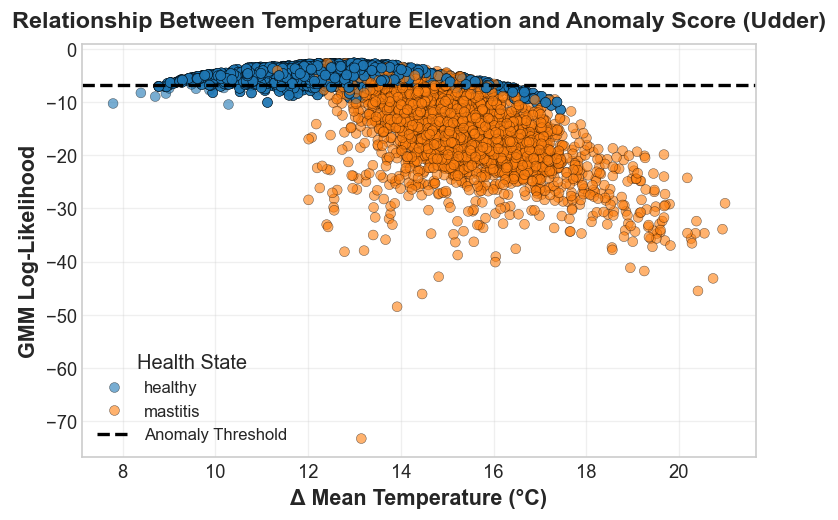

In [91]:
plt.figure(figsize=(6.5,4.5))

sns.scatterplot(
    data=df[df["cow_part"] == "udder"],
    x="delta_mean",
    y="gmm_score",
    hue="health_state",
    alpha=0.6,
    s=35,                 # slightly larger points
    edgecolor="black",    # improves visibility
    linewidth=0.3
)

# Threshold line (clearer)
plt.axhline(
    thresholds["udder"],
    color="black",
    linestyle="--",
    linewidth=2,
    label="Anomaly Threshold"
)

# Bold, readable labels
plt.xlabel(
    "Δ Mean Temperature (°C)",
    fontsize=13,
    fontweight="bold"
)
plt.ylabel(
    "GMM Log-Likelihood",
    fontsize=13,
    fontweight="bold"
)

plt.title(
    "Relationship Between Temperature Elevation and Anomaly Score (Udder)",
    fontsize=14,
    fontweight="bold",
    pad=10
)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.legend(title="Health State", fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


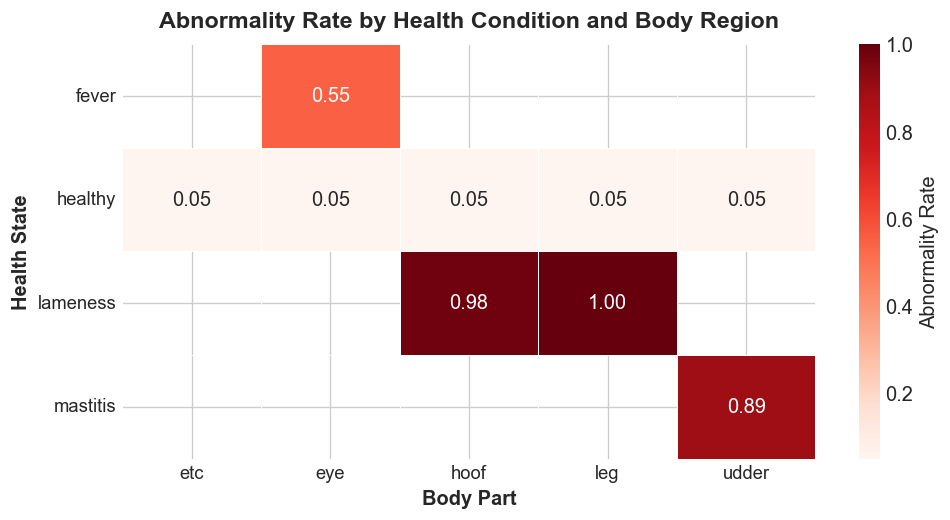

In [92]:
abnormal_rate = (
    df.groupby(["health_state", "cow_part"])["abnormal"]
    .mean()
    .unstack()
)

plt.figure(figsize=(8.5,4.5))

sns.heatmap(
    abnormal_rate,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    linewidths=0.6,        # cell separation
    linecolor="white",
    cbar_kws={"label": "Abnormality Rate"}
)

plt.title(
    "Abnormality Rate by Health Condition and Body Region",
    fontsize=14,
    fontweight="bold",
    pad=10
)

plt.xlabel(
    "Body Part",
    fontsize=12,
    fontweight="bold"
)
plt.ylabel(
    "Health State",
    fontsize=12,
    fontweight="bold"
)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11, rotation=0)

plt.tight_layout()
plt.show()


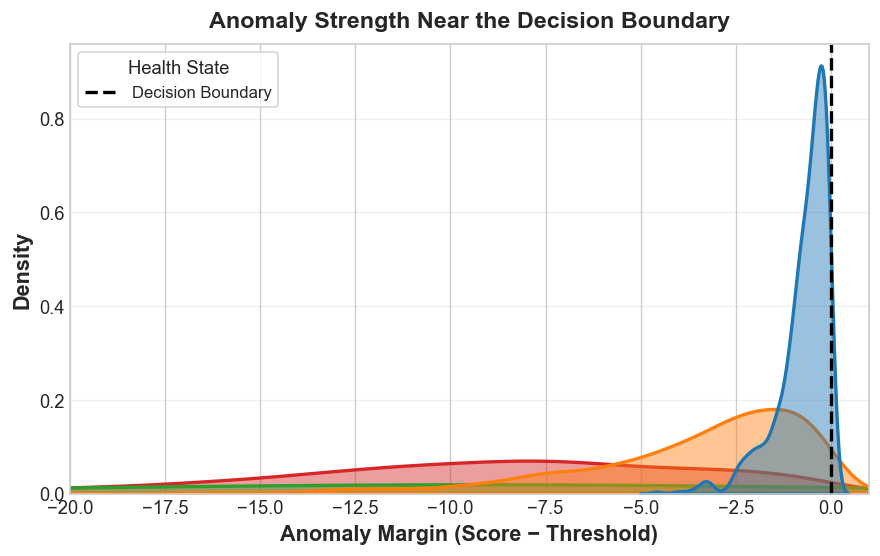

In [95]:
plt.figure(figsize=(7.5,4.8))

sns.kdeplot(
    data=abnormal_df,
    x="anomaly_margin",
    hue="health_state",
    common_norm=False,
    fill=True,
    alpha=0.45,
    linewidth=2
)

# Decision boundary
plt.axvline(
    0,
    color="black",
    linestyle="--",
    linewidth=2,
    label="Decision Boundary"
)

plt.xlim(-20, 1)

# Bold, readable labels
plt.xlabel(
    "Anomaly Margin (Score − Threshold)",
    fontsize=13,
    fontweight="bold"
)
plt.ylabel(
    "Density",
    fontsize=13,
    fontweight="bold"
)

plt.title(
    "Anomaly Strength Near the Decision Boundary",
    fontsize=14,
    fontweight="bold",
    pad=10
)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.legend(
    title="Health State",
    fontsize=10,
    title_fontsize=11,
    frameon=True
)

plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


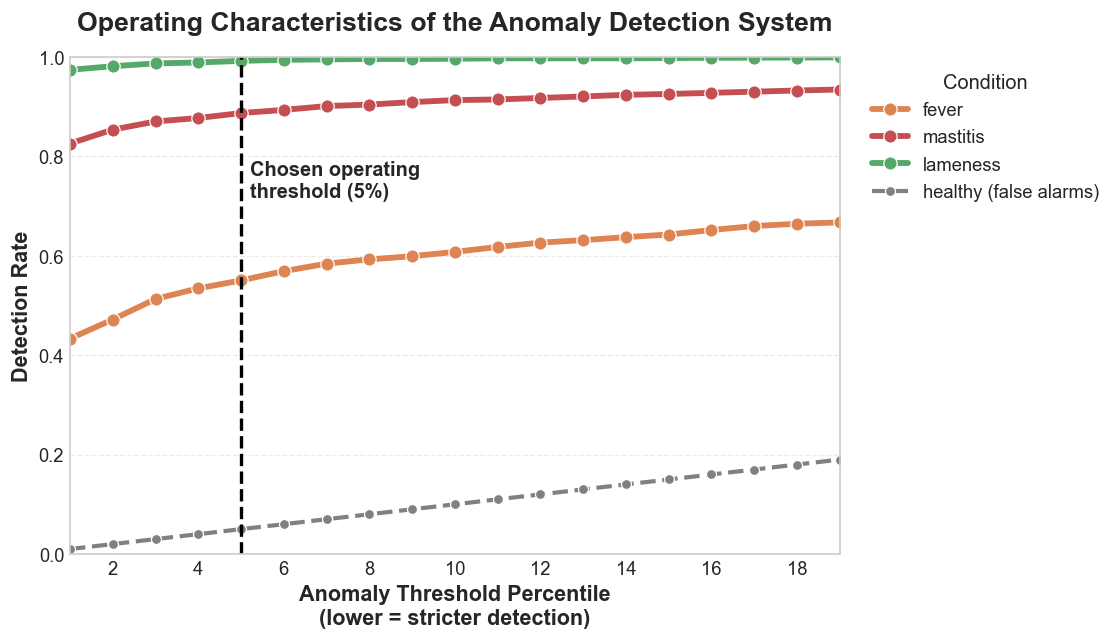

In [125]:
import numpy as np

# Define a range of threshold percentiles
percentiles = np.arange(1, 20, 1)  # 1% → 20%

curve_data = []

for p in percentiles:
    temp_thresholds = {}

    # recompute thresholds per body part
    for part in thresholds.keys():
        healthy_scores = df[
            (df["cow_part"] == part) &
            (df["health_state"] == "healthy")
        ]["gmm_score"]

        temp_thresholds[part] = np.percentile(healthy_scores, p)

    # flag abnormal with temporary thresholds
    temp_abnormal = df.apply(
        lambda r: int(
            r["gmm_score"] < temp_thresholds.get(r["cow_part"], -999)
        ),
        axis=1
    )

    # compute detection rate per disease
    rates = (
        pd.crosstab(df["health_state"], temp_abnormal, normalize="index")
        .get(1, pd.Series(0))
    )

    for state, rate in rates.items():
        curve_data.append({
            "percentile": p,
            "health_state": state,
            "detection_rate": rate
        })
curve_df = pd.DataFrame(curve_data)

# Order diseases for visual clarity
order = ["healthy", "fever", "mastitis", "lameness"]
curve_df["health_state"] = pd.Categorical(
    curve_df["health_state"], categories=order, ordered=True
)

plt.figure(figsize=(9.5,5.5))

# Split data
diseases = curve_df[curve_df["health_state"] != "healthy"]
healthy_df = curve_df[curve_df["health_state"] == "healthy"]

# Explicit order for diseases
disease_order = ["fever", "mastitis", "lameness"]

palette = {
    "fever": "#DD8452",
    "mastitis": "#C44E52",
    "lameness": "#55A868"
}

# ---- PRIMARY: Disease detection curves ----
sns.lineplot(
    data=diseases,
    x="percentile",
    y="detection_rate",
    hue="health_state",
    hue_order=disease_order,
    palette=palette,
    linewidth=3.5,          # 🔥 bolder
    marker="o",
    markersize=8
)

# ---- SECONDARY: Healthy (false alarms) ----
sns.lineplot(
    data=healthy_df,
    x="percentile",
    y="detection_rate",
    color="gray",
    linewidth=2.5,
    linestyle="--",
    marker="o",
    markersize=6,
    label="healthy (false alarms)"
)

# ---- Operating threshold ----
plt.axvline(
    5,
    color="black",
    linestyle="--",
    linewidth=2
)

plt.text(
    5.2, 0.75,
    "Chosen operating\nthreshold (5%)",
    fontsize=12,
    fontweight="bold",
    verticalalignment="center"
)

# ---- Labels (BOLD & READABLE) ----
plt.xlabel(
    "Anomaly Threshold Percentile\n(lower = stricter detection)",
    fontsize=13,
    fontweight="bold"
)
plt.ylabel(
    "Detection Rate",
    fontsize=13,
    fontweight="bold"
)

# ---- Title ----
plt.title(
    "Operating Characteristics of the Anomaly Detection System",
    fontsize=16,
    fontweight="bold",
    pad=16
)

# ---- Axes formatting ----
plt.ylim(0, 1)
plt.xlim(curve_df["percentile"].min(), curve_df["percentile"].max())
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# ---- Legend ----
plt.legend(
    title="Condition",
    title_fontsize=12,
    fontsize=11,
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False
)

# ---- Grid (subtle, professional) ----
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.grid(False, axis="x")

plt.tight_layout()
plt.show()




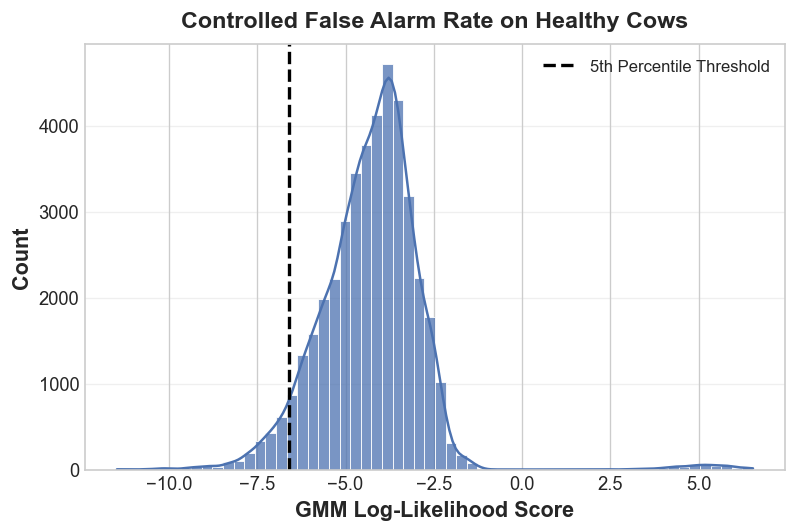

In [96]:
plt.figure(figsize=(6.8,4.6))

healthy_scores = df[df["health_state"] == "healthy"]["gmm_score"]
threshold_5 = np.percentile(healthy_scores, 5)

sns.histplot(
    healthy_scores,
    bins=60,
    kde=True,
    color="#4C72B0",
    alpha=0.75,
    edgecolor="white",
    linewidth=0.5
)

# Threshold line
plt.axvline(
    threshold_5,
    color="black",
    linestyle="--",
    linewidth=2,
    label="5th Percentile Threshold"
)

# Labels (bold & readable)
plt.xlabel(
    "GMM Log-Likelihood Score",
    fontsize=13,
    fontweight="bold"
)
plt.ylabel(
    "Count",
    fontsize=13,
    fontweight="bold"
)

plt.title(
    "Controlled False Alarm Rate on Healthy Cows",
    fontsize=14,
    fontweight="bold",
    pad=10
)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.legend(fontsize=10)
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


In [98]:
# --- Feature sensitivity via perturbation ---
base_df = df[df["health_state"] == "healthy"].copy()

sensitivities = []

for feature in FEATURES:
    deltas = []

    for part in base_df["cow_part"].unique():
        part_df = base_df[base_df["cow_part"] == part].copy()
        if part not in gmm_models:
            continue

        X = scalers[part].transform(part_df[FEATURES])
        base_score = gmm_models[part].score_samples(X)

        perturbed = part_df.copy()
        perturbed[feature] += 0.5  # small physiological perturbation
        Xp = scalers[part].transform(perturbed[FEATURES])
        pert_score = gmm_models[part].score_samples(Xp)

        deltas.extend(np.abs(pert_score - base_score))

    sensitivities.append({
        "feature": feature,
        "mean_score_change": np.mean(deltas)
    })

sens_df = pd.DataFrame(sensitivities).sort_values("mean_score_change")


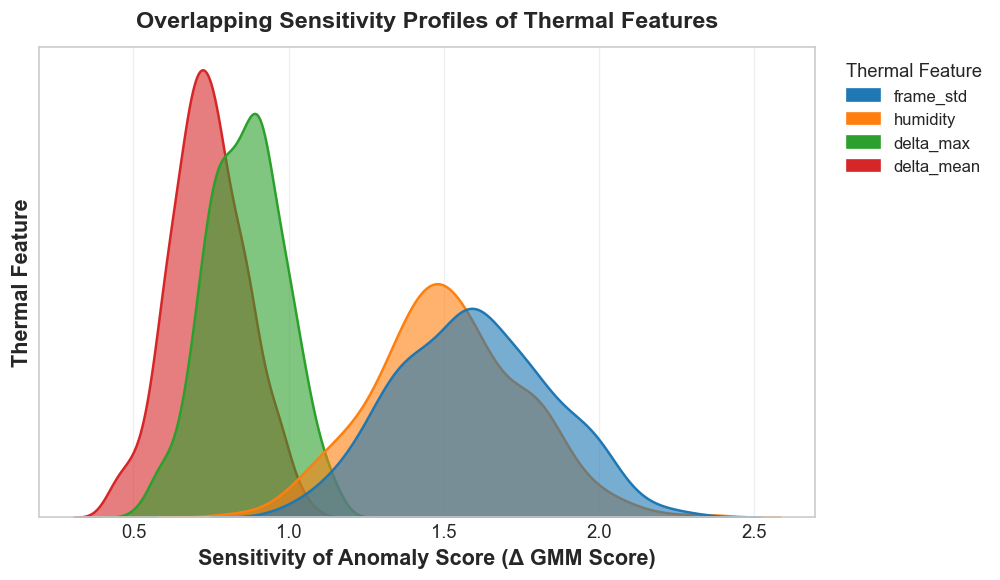

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Prepare synthetic distributions around sensitivity values
ridge_data = []

for _, row in sens_df.iterrows():
    samples = np.random.normal(
        loc=row["mean_score_change"],
        scale=row["mean_score_change"] * 0.15 + 0.01,
        size=300
    )
    for s in samples:
        ridge_data.append({
            "feature": row["feature"],
            "sensitivity": s
        })

ridge_df = pd.DataFrame(ridge_data)

# Order features by sensitivity (most influential on top)
order = sens_df.sort_values(
    "mean_score_change", ascending=False
)["feature"]

# Color palette: distinct, readable
palette = sns.color_palette("tab10", n_colors=len(order))
import matplotlib.patches as mpatches

plt.figure(figsize=(8.5,5))

ax = sns.kdeplot(
    data=ridge_df,
    x="sensitivity",
    hue="feature",
    hue_order=order,
    fill=True,
    common_norm=False,
    alpha=0.6,
    linewidth=1.5,
    palette=palette,
    legend=False   # 🔑 turn off seaborn legend
)

# ---- MANUAL LEGEND ----
handles = [
    mpatches.Patch(color=palette[i], label=feat)
    for i, feat in enumerate(order)
]

plt.legend(
    handles=handles,
    title="Thermal Feature",
    fontsize=10,
    title_fontsize=11,
    frameon=False,
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)

# ---- LABELS & STYLE ----
plt.xlabel(
    "Sensitivity of Anomaly Score (Δ GMM Score)",
    fontsize=13,
    fontweight="bold"
)
plt.ylabel(
    "Thermal Feature",
    fontsize=13,
    fontweight="bold"
)

plt.title(
    "Overlapping Sensitivity Profiles of Thermal Features",
    fontsize=14,
    fontweight="bold",
    pad=12
)

plt.xticks(fontsize=11)
plt.yticks([])
plt.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.show()



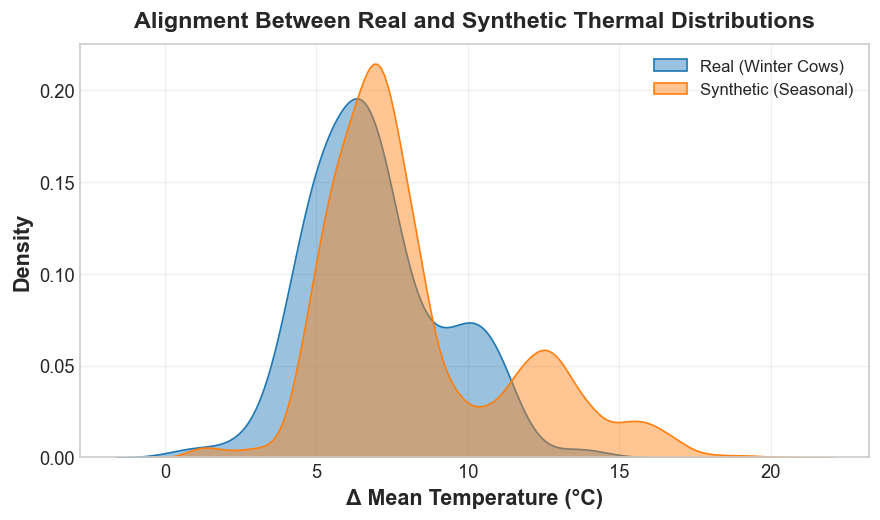

In [102]:
plt.figure(figsize=(7.5,4.5))

sns.kdeplot(
    data=df[df["lactation"] == 0],
    x="delta_mean",
    fill=True,
    alpha=0.45,
    label="Real (Winter Cows)"
)

sns.kdeplot(
    data=df[df["lactation"] == 1],
    x="delta_mean",
    fill=True,
    alpha=0.45,
    label="Synthetic (Seasonal)"
)

plt.xlabel(
    "Δ Mean Temperature (°C)",
    fontsize=13,
    fontweight="bold"
)
plt.ylabel(
    "Density",
    fontsize=13,
    fontweight="bold"
)

plt.title(
    "Alignment Between Real and Synthetic Thermal Distributions",
    fontsize=14,
    fontweight="bold",
    pad=10
)

plt.legend(fontsize=10)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


MORE

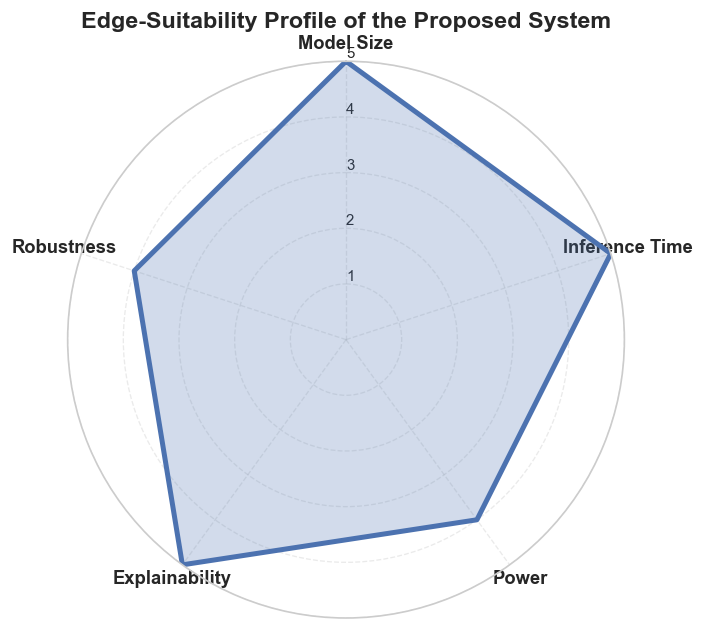

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Data
labels = ["Model Size", "Inference Time", "Power", "Explainability", "Robustness"]
values = [5, 5, 4, 5, 4]

# Close the loop
values = values + [values[0]]
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles = np.concatenate([angles, [angles[0]]])

# Create figure
fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))

# Rotate so first axis is at the top
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Axis labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=11, fontweight="bold")

# Radial scale
ax.set_rlabel_position(0)
ax.set_yticks([1, 2, 3, 4, 5])
ax.set_yticklabels(["1", "2", "3", "4", "5"], fontsize=9)
ax.set_ylim(0, 5)

# Grid styling
ax.yaxis.grid(True, linestyle="--", alpha=0.4)
ax.xaxis.grid(True, linestyle="--", alpha=0.4)

# Plot radar
ax.plot(
    angles,
    values,
    linewidth=3,
    linestyle="-",
    color="#4C72B0"
)

ax.fill(
    angles,
    values,
    color="#4C72B0",
    alpha=0.25
)

# Title
ax.set_title(
    "Edge-Suitability Profile of the Proposed System",
    fontsize=14,
    fontweight="bold",
    pad=20
)

plt.tight_layout()
plt.show()


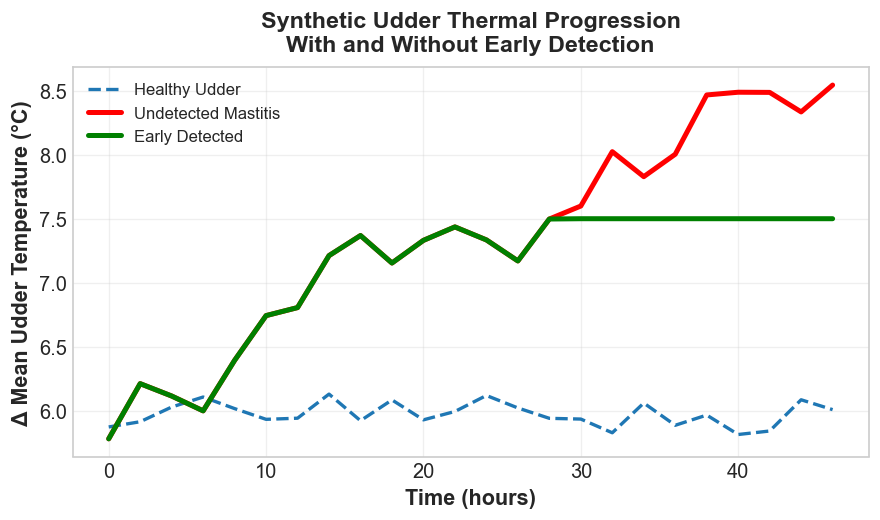

In [124]:
time = np.arange(0, 48, 2)  # hours

# Synthetic but physiologically plausible
healthy = np.full_like(time, 6.0) + np.random.normal(0, 0.1, len(time))
undetected = 6.0 + 0.06 * time + np.random.normal(0, 0.2, len(time))
detected = np.minimum(undetected, 7.5)

plt.figure(figsize=(7.5,4.5))

plt.plot(time, healthy, "--", linewidth=2, label="Healthy Udder")
plt.plot(time, undetected, linewidth=3, color="red", label="Undetected Mastitis")
plt.plot(time, detected, linewidth=3, color="green", label="Early Detected")

plt.xlabel("Time (hours)", fontsize=13, fontweight="bold")
plt.ylabel("Δ Mean Udder Temperature (°C)", fontsize=13, fontweight="bold")

plt.title(
    "Synthetic Udder Thermal Progression\nWith and Without Early Detection",
    fontsize=14,
    fontweight="bold",
    pad=10
)

plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


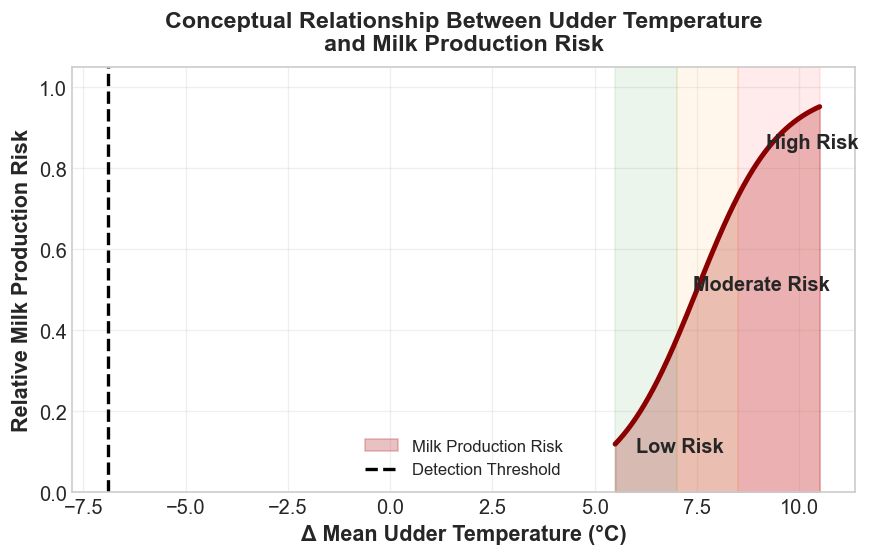

In [120]:
delta_temp = np.linspace(5.5, 10.5, 300)
risk = 1 / (1 + np.exp(-(delta_temp - 7.5)))

plt.figure(figsize=(7.5,4.8))

# Filled risk area
plt.fill_between(
    delta_temp,
    risk,
    color="#C44E52",
    alpha=0.35,
    label="Milk Production Risk"
)

# Risk curve
plt.plot(
    delta_temp,
    risk,
    linewidth=3,
    color="#8B0000"
)

# Detection threshold
plt.axvline(
    thresholds["udder"],
    linestyle="--",
    color="black",
    linewidth=2,
    label="Detection Threshold"
)

# Risk zones
plt.axvspan(5.5, 7.0, color="green", alpha=0.08)
plt.axvspan(7.0, 8.5, color="orange", alpha=0.08)
plt.axvspan(8.5, 10.5, color="red", alpha=0.08)

plt.text(6.0, 0.1, "Low Risk", fontweight="bold")
plt.text(7.4, 0.5, "Moderate Risk", fontweight="bold")
plt.text(9.2, 0.85, "High Risk", fontweight="bold")

plt.xlabel(
    "Δ Mean Udder Temperature (°C)",
    fontsize=13,
    fontweight="bold"
)
plt.ylabel(
    "Relative Milk Production Risk",
    fontsize=13,
    fontweight="bold"
)

plt.title(
    "Conceptual Relationship Between Udder Temperature\nand Milk Production Risk",
    fontsize=14,
    fontweight="bold",
    pad=10
)

plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()


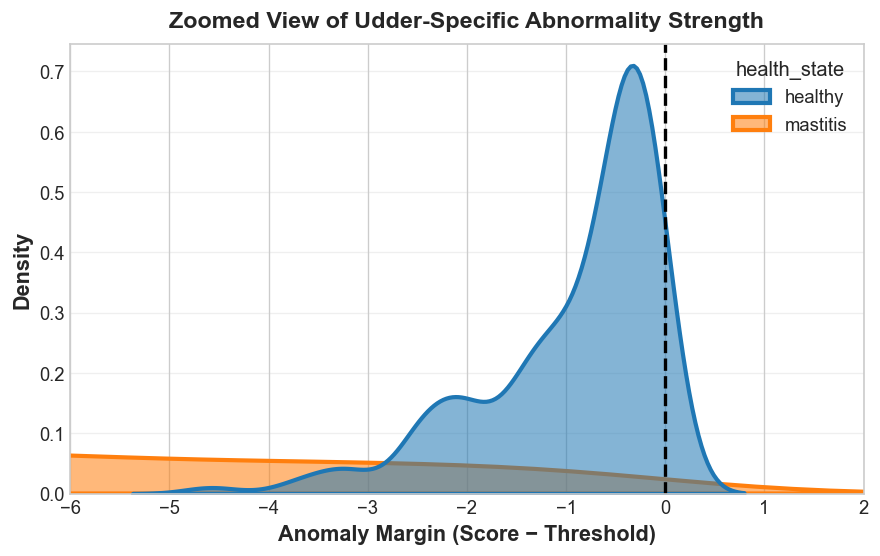

In [121]:
udder_abn = df[
    (df["cow_part"] == "udder") &
    (df["abnormal"] == 1)
].copy()

plt.figure(figsize=(7.5,4.8))

sns.kdeplot(
    data=udder_abn,
    x="anomaly_margin",
    hue="health_state",
    fill=True,
    common_norm=False,
    alpha=0.55,
    linewidth=2.5
)

# Decision boundary
plt.axvline(0, linestyle="--", color="black", linewidth=2)

# 🔍 ZOOM near decision boundary
plt.xlim(-6, 2)

plt.xlabel(
    "Anomaly Margin (Score − Threshold)",
    fontsize=13,
    fontweight="bold"
)
plt.ylabel(
    "Density",
    fontsize=13,
    fontweight="bold"
)

plt.title(
    "Zoomed View of Udder-Specific Abnormality Strength",
    fontsize=14,
    fontweight="bold",
    pad=10
)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


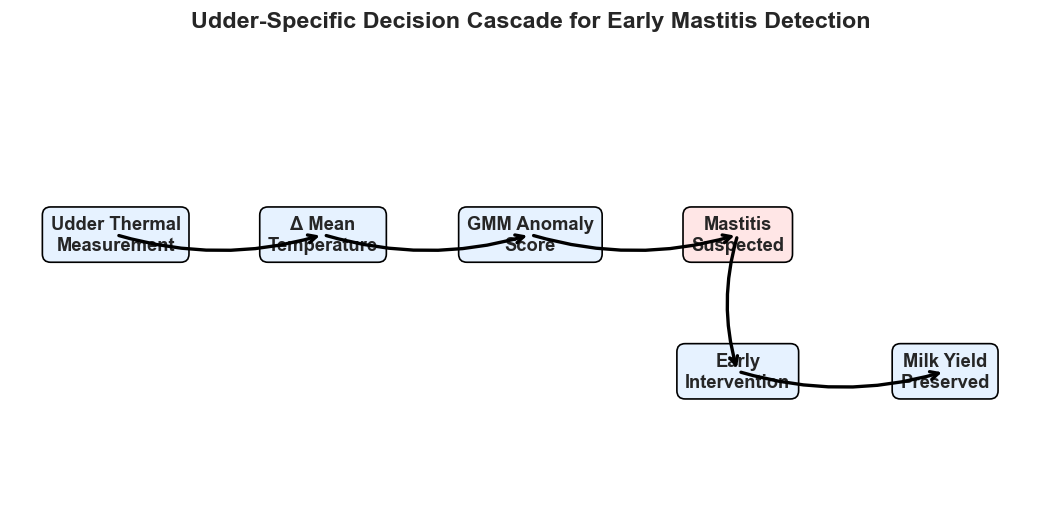

In [122]:
fig, ax = plt.subplots(figsize=(9,4.5))
ax.axis("off")

# Positions
nodes = {
    "measure": (0.1, 0.6),
    "delta": (0.3, 0.6),
    "gmm": (0.5, 0.6),
    "decision": (0.7, 0.6),
    "action": (0.7, 0.3),
    "milk": (0.9, 0.3)
}

labels = {
    "measure": "Udder Thermal\nMeasurement",
    "delta": "Δ Mean\nTemperature",
    "gmm": "GMM Anomaly\nScore",
    "decision": "Mastitis\nSuspected",
    "action": "Early\nIntervention",
    "milk": "Milk Yield\nPreserved"
}

# Draw nodes
for key, (x, y) in nodes.items():
    ax.text(
        x, y, labels[key],
        ha="center", va="center",
        fontsize=11,
        fontweight="bold",
        bbox=dict(
            boxstyle="round,pad=0.45",
            fc="#FFE6E6" if key == "decision" else "#E6F2FF",
            ec="black"
        )
    )

# Draw arrows
arrows = [
    ("measure", "delta"),
    ("delta", "gmm"),
    ("gmm", "decision"),
    ("decision", "action"),
    ("action", "milk")
]

for a, b in arrows:
    ax.annotate(
        "",
        xy=nodes[b],
        xytext=nodes[a],
        arrowprops=dict(
            arrowstyle="->",
            linewidth=2,
            connectionstyle="arc3,rad=0.15"
        )
    )

plt.title(
    "Udder-Specific Decision Cascade for Early Mastitis Detection",
    fontsize=14,
    fontweight="bold",
    pad=15
)

plt.tight_layout()
plt.show()


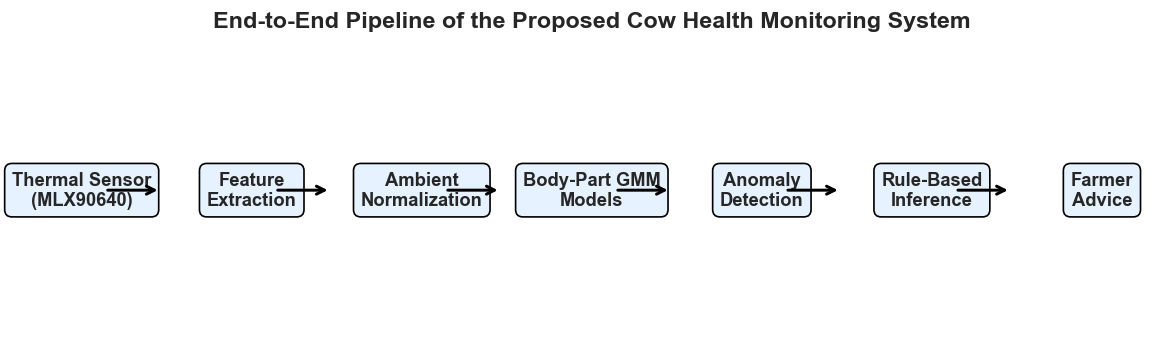

In [123]:
fig, ax = plt.subplots(figsize=(10,3))

ax.axis("off")

steps = [
    "Thermal Sensor\n(MLX90640)",
    "Feature\nExtraction",
    "Ambient\nNormalization",
    "Body-Part GMM\nModels",
    "Anomaly\nDetection",
    "Rule-Based\nInference",
    "Farmer\nAdvice"
]

x_positions = np.linspace(0.05, 0.95, len(steps))

for x, step in zip(x_positions, steps):
    ax.text(
        x, 0.5, step,
        ha="center", va="center",
        fontsize=11,
        fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.4", fc="#E6F2FF", ec="black")
    )

    if x != x_positions[-1]:
        ax.annotate(
            "",
            xy=(x + 0.07, 0.5),
            xytext=(x + 0.02, 0.5),
            arrowprops=dict(arrowstyle="->", linewidth=1.8)
        )

plt.title(
    "End-to-End Pipeline of the Proposed Cow Health Monitoring System",
    fontsize=14,
    fontweight="bold",
    pad=15
)

plt.tight_layout()
plt.show()
